<center> </center>

<center><font size=5 face="Helvetica" color=#EE4B2B><b>
Pytorch Tutorial: Datasets & Dataloaders
</b></font></center>

<center><font face="Helvetica" size=3><b>Ang Chen</b></font></center>
<center><font face="Helvetica" size=3>July, 2024</font></center>

***

Code for processing data samples can get messy and hard to maintain;
we ideally want our dataset code to be decoupled from our model training code for better readability and modularity.
Pytorch provides two data promitives: $\texttt{torch.utils.data.DataLoader}$ and $\texttt{torch.utils.data.Dataset}$ that 
allow you to use pre-loaded datasets as well as your own data.
$\texttt{Dataset}$ stores the samples and their corresponding labels, and $\texttt{DataLoader}$ wraps an iterable around the $\texttt{Dataset}$ 
to enable easy access to the samples.

Pytorch domain libraries provide a number of pre-loaded datasets (such as FashionMNIST) that subclass $\texttt{torch.utils.data.Dataset}$ and implement functions specific to the particular data.
They can be used to prototype and benchmark your model.


# Loading a Dataset

Here is an example of how to load the Fashion-MNIST dataset from TorchVision.
Fashion-MNIST is a dataset of Zalando's article images consisting of 60,000 training examples and 10,000 test examples.
Each example is a 28$\times$28 grayscale image, associated with a label from one of 10 classes.

We load the FashionMNIST Dataset with the following parameters:
 * $\texttt{root}$ is the path where the train/test data is stored,
 * $\texttt{train}$ sppecifies training or test dataset,
 * $\texttt{download=True}$ downloads the data from the internet if it's not avaialable at $\texttt{root}$.
 * $\texttt{transform}$ and $\texttt{target\_transform}$ specify the feature and label transformations.
 

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = "Helvetica"
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# Iterating and Visualizing the Dataset

We can index $\texttt{Datasets}$ manually like a list: $\texttt{training\_data[index]}$. 
We use $\texttt{matplotlib}$ to visualize some samples in our training data.

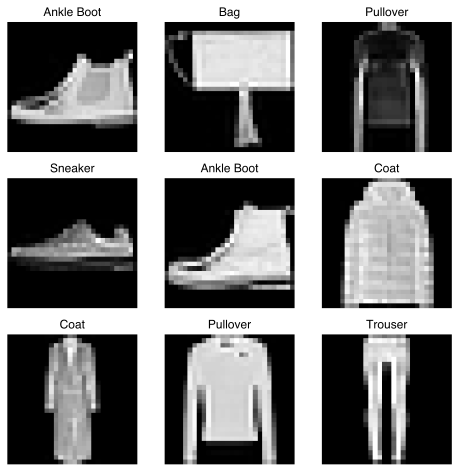

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# Creating a Custom Dataset for your files

A custom Dataset class must implement three functions:  $\texttt{\_\_init\_\_}$, $\texttt{\_\_len\_\_}$, and $\texttt{\_\_getitem\_\_}$.
Take a look at this implementation; the FashionMNIST images are stored in a directory $\texttt{img\_dir}$, and their labels are stored in a CSV file $\texttt{annotations\_file}$.

In the next sections, we'll break down what's happening in each of these functions.

In [4]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

## $\texttt{\_\_init\_\_}$

The $\texttt{\_\_init\_\_}$ function is run once when instantiating the Dataset object.
We initialize the directory containing the images, the annotations files, and both transforms.

## $\texttt{\_\_len\_\_}$

The $\texttt{\_\_len\_\_}$ function returns the number of samples in our dataset.

## $\texttt{\_\_getitem\_\_}$

The $\texttt{\_\_getitem\_\_}$ function loads and returns a sample from the dataset at the given index $\texttt{idx}$.
Based on the index, it identifies the image's location on disk, coverts that to a tensor using $\texttt{read\_image}$, retrieves the corresponding label from the csv data in $\texttt{self.img\_labels}$, calls the transform functions on them (if applicable), and returns the tensor image and corresponding label in a tuple.

# Preparing your data for training with DataLoaders

The $\texttt{Dataset}$ retrieves our dataset's our dataset's features and labels one sample at a time.
While training a model, we typically want to pass samples in "minibatches", reshuffle the data at every epoch to reduce model overfitting, and use Python's $\texttt{multiprocessing}$ to speed up data retrieval.

$\texttt{DataLoader}$ is an iterable that abstracts this complexity for us in an easy API.

In [5]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

# Iterate through the DataLoader

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


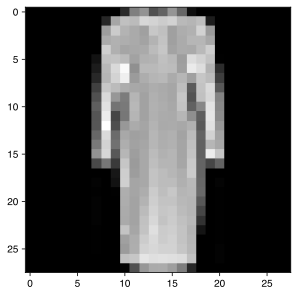

Label: 3


In [6]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")